In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import warnings
warnings.filterwarnings('ignore')

---

General variables and dictionaries

In [2]:
VARIABLE = 'MonthlyIncome'
VARIABLE2 = 'Monthly income'

PREDICTOR = 'YearsOfEducation'
PREDICTOR2 = 'Years of education'

VARIABLEPROVINCEMAP = 'Province monthly income mean'
VARIABLEREGIONMAP   = 'Region monthly income mean'

COMPARE_METRIC = 'waic' # metric for comparing the models, options are 'waic' or 'loo'

ALPHA_LEVEL = 0.05

J = 6 # Number of regions

In [3]:
RegionsToNumbers = {
    'Bangkok - Pattaya': 0
    , 'Central Thailand': 1
    , 'Northcentral Thailand': 2
    , 'Northeastern Thailand': 3
    , 'Southern Thailand': 4
    , 'Northern Thailand': 5
}

In [4]:
NumbersToRegions = {
    0: 'Bangkok - Pattaya'
    , 1: 'Central Thailand'
    , 2: 'Northcentral Thailand'
    , 3: 'Northeastern Thailand'
    , 4: 'Southern Thailand'
    , 5: 'Northern Thailand'
}

In [5]:
def Gauss2d(mu, cov, ci, ax=None):
    """Copied from statsmodel"""
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))

    v_, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees

    for level in ci:
        v = 2 * np.sqrt(v_ * stats.chi2.ppf(level, 2))  # get size corresponding to level
        ell = Ellipse(
            mu[:2],
            v[0],
            v[1],
            180 + angle,
            facecolor="None",
            edgecolor="k",
            alpha=(1 - level) * 0.5,
            lw=1.5,
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

    return ax

---

Read the data and give it the basic needed structure

In [6]:
Dat = pd.read_csv("../../../Data/Processed/DataProvince.csv")
ProvincesProvinceIdRegion = pd.read_csv("../../../Data/Processed/ProposedRegions.csv")

In [7]:
Dat = pd.merge(Dat, ProvincesProvinceIdRegion)
Dat = Dat.rename(columns={'Proposed Region': 'Region'})
Dat['RegionNumber'] = Dat['Region'].replace(RegionsToNumbers)

In [8]:
Dat = Dat[['ProvinceId', VARIABLE + 'Mean', PREDICTOR, 'RegionNumber']]

In [9]:
PredictorMean = Dat[PREDICTOR].mean()

---

In [10]:
DatRegion = Dat[[PREDICTOR, 'RegionNumber']].groupby(['RegionNumber']).mean().reset_index()
DatRegion = DatRegion.rename(columns={PREDICTOR: PREDICTOR + 'Region'})

Dat = pd.merge(Dat, DatRegion)

Calculate the statistics per region

In [11]:
DatRegion = Dat[[VARIABLE + 'Mean', 'RegionNumber']].groupby(['RegionNumber']).agg(['mean', 'std']).reset_index()

DatRegion.columns = DatRegion.columns.droplevel()

DatRegion = DatRegion.rename(
    columns={
        '': 'RegionNumber'
        , 'mean': VARIABLE + 'Mean'
        , 'std': VARIABLE + 'Std'
    }
)

Get the average years of education per region

In [12]:
Dat[[PREDICTOR, 'RegionNumber']].groupby(['RegionNumber']).agg(['mean', 'std']).reset_index()

RegionNumber YearsOfEducation          
                           mean       std
0            0        12.523685  0.525608
1            1        11.162240  0.470984
2            2        10.420890  0.365433
3            3        10.484613  0.276904
4            4        11.259060  0.526391
5            5        10.315753  0.511401

---

Estimate $\nu$ for all the data

In [13]:
ES2 = (DatRegion[VARIABLE + 'Std']**2).mean()
VS2 = (DatRegion[VARIABLE + 'Std']**2).var()

HatNu = 2 * ES2**2 / VS2 + 4

---

Regression model with common $\alpha$ and $\beta$

In [14]:
with pm.Model() as ModelCommonAlphaCommonBeta:
    Alpha = pm.Flat('Alpha')
    Beta  = pm.Flat('Beta')

    Sigma = pm.HalfFlat('Sigma')
    pm.Potential('p(Sigma)', 1/Sigma)

    MeanIncome = pm.Deterministic('MeanIncome', Alpha + Beta * (Dat[PREDICTOR] - PredictorMean))

    Income = pm.Normal('Income', mu=MeanIncome, sigma=Sigma, observed=Dat[VARIABLE + 'Mean'])

Regression model with separate $\alpha$'s and $\beta$'s

In [15]:
Dat

,ProvinceId,MonthlyIncomeMean,YearsOfEducation,RegionNumber,YearsOfEducationRegion
0,26,22653.415514,11.202366,1,11.162240
1,76,22444.761780,11.285787,1,11.162240
2,22,26586.706041,10.445461,1,11.162240
3,19,24150.395582,11.487707,1,11.162240
4,17,19549.969624,11.256410,1,11.162240
...,...,...,...,...,...
71,13,20972.148336,12.780891,0,12.523685
72,20,22178.539065,11.977991,0,12.523685
73,21,23380.246849,11.923714,0,12.523685
74,11,18904.076482,12.627912,0,12.523685


In [16]:
with pm.Model() as ModelSeparateAlphaSeparateBeta:
    Alpha = pm.Flat('Alpha', shape=J)
    Beta  = pm.Flat('Beta', shape=J)

    Sigma = pm.HalfFlat('Sigma', shape=J)
    pm.Potential('p(Sigma)', 1/Sigma)

    MeanIncome = pm.Deterministic(
        'MeanIncome'
        , Alpha[Dat['RegionNumber']] + Beta[Dat['RegionNumber']] * (Dat[PREDICTOR] - Dat[PREDICTOR + 'Region']))

    Income = pm.Normal('Income', mu=MeanIncome, sigma=Sigma[Dat['RegionNumber']], observed=Dat[VARIABLE + 'Mean'])

---

In [17]:
TraceCommonAlphaCommonBeta = pm.sample(model = ModelCommonAlphaCommonBeta)
TraceSeparateAlphaSeparateBeta = pm.sample(model = ModelSeparateAlphaSeparateBeta)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, Beta, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, Beta, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


In [18]:
HatMeanMu = TraceCommonAlphaCommonBeta.posterior.Alpha.values.mean()
HatStdMu  = TraceCommonAlphaCommonBeta.posterior.Alpha.values.std()

HatMeanTau = float(TraceSeparateAlphaSeparateBeta.posterior.Alpha.mean(('chain', 'draw')).std().values)

HatMeanGamma = TraceCommonAlphaCommonBeta.posterior.Beta.values.mean()
HatStdGamma  = TraceCommonAlphaCommonBeta.posterior.Beta.values.std()

HatMeanZeta = float(TraceSeparateAlphaSeparateBeta.posterior.Beta.mean(('chain', 'draw')).std().values)

---

In [19]:
with pm.Model() as ModelVaryingAlphaVaryingBeta:

    Chol, RhoAlphaBeta, CovAlphaBeta = pm.LKJCholeskyCov(
        "chol_cov"
        , n=2
        , eta=2
        , sd_dist=pm.Exponential.dist(lam=[1/HatMeanTau, 1/HatMeanZeta])
        , compute_corr=True
    )

    Mu    = pm.Normal('Mu', mu=HatMeanMu, sigma=HatStdMu)
    Gamma = pm.Normal('Gamma', mu=HatMeanGamma, sigma=HatStdGamma)

    AlphaBeta = pm.MvNormal("AlphaBeta", mu=[Mu, Gamma], chol=Chol, shape=(J, 2))

    Rho = pm.HalfFlat('Rho')
    pm.Potential('p(Rho)', -pm.math.log(Rho))

    Nu = pm.Exponential('Nu', lam=1/HatNu)

    Sigma2 = pm.InverseGamma('Sigma2', alpha=Nu/2, beta=Nu/2 * Rho**2, shape=J)
    Sigma  = pm.Deterministic('Sigma', pm.math.sqrt(Sigma2))

    MeanIncome = pm.Deterministic(
        'MeanIncome'
        , AlphaBeta[Dat['RegionNumber'], 0] + AlphaBeta[Dat['RegionNumber'], 1] * (Dat[PREDICTOR] - Dat[PREDICTOR + 'Region'])
    )

    Income = pm.Laplace(
        'Income'
        , mu = MeanIncome
        , b  = Sigma[Dat['RegionNumber']]
        , observed = Dat[VARIABLE + 'Mean']
    )

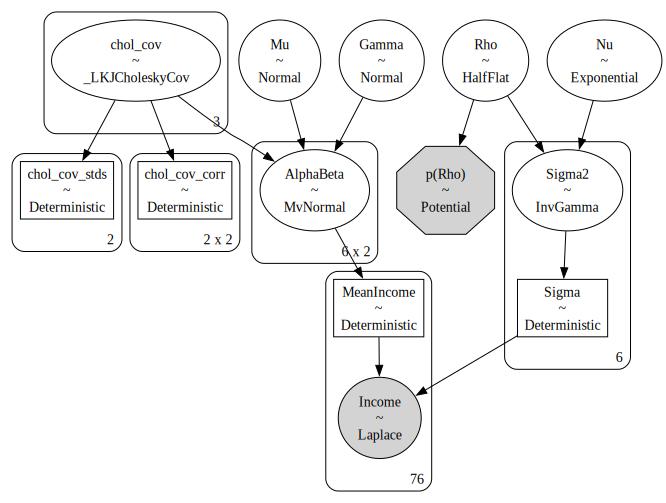

In [20]:
pm.model_to_graphviz(ModelVaryingAlphaVaryingBeta)

Get a sample from the posterior and the posterior predictive

In [21]:
with ModelVaryingAlphaVaryingBeta:
    TraceVaryingAlphaVaryingBeta = pm.sample()
    TraceVaryingAlphaVaryingBeta.extend(pm.sample_posterior_predictive(TraceVaryingAlphaVaryingBeta))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol_cov, Mu, Gamma, AlphaBeta, Rho, Nu, Sigma2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 95 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 152 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [Income]


---

Regional average income, ratio of income per year-of-education

In [22]:
DatRegion['Region'] = DatRegion['RegionNumber'].replace(NumbersToRegions)

In [23]:
PosteriorAlpha = az.summary(
    TraceVaryingAlphaVaryingBeta.posterior.AlphaBeta[:,:,:,0]
    , kind = 'stats'
    , hdi_prob = 1-ALPHA_LEVEL
    , var_names = 'AlphaBeta'
)

PosteriorAlpha = PosteriorAlpha.rename(
    columns = {
        'mean': 'HatAlpha'
        , 'hdi_' + str((ALPHA_LEVEL/2)*100)  + '%': 'LowAlpha'
        , 'hdi_' + str((1-ALPHA_LEVEL/2)*100)  + '%': 'UppAlpha'
    }
)

In [24]:
PosteriorBeta = az.summary(
    TraceVaryingAlphaVaryingBeta.posterior.AlphaBeta[:,:,:,1]
    , kind = 'stats'
    , hdi_prob = 1-ALPHA_LEVEL
    , var_names = 'AlphaBeta'
)

PosteriorBeta = PosteriorBeta.rename(
    columns = {
        'mean': 'HatBeta'
        , 'hdi_' + str((ALPHA_LEVEL/2)*100)  + '%': 'LowBeta'
        , 'hdi_' + str((1-ALPHA_LEVEL/2)*100)  + '%': 'UppBeta'
    }
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


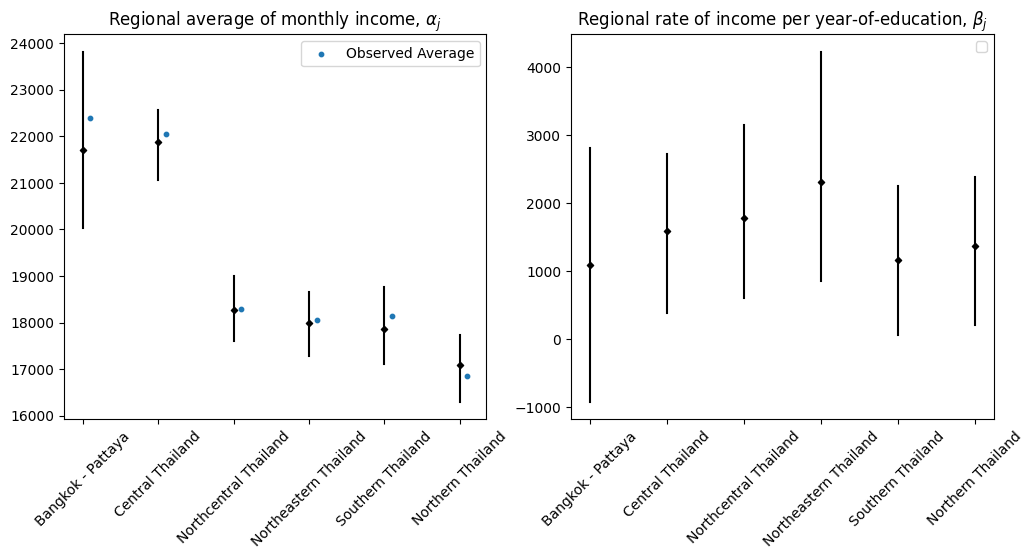

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

for k, ax in enumerate(axs.reshape(-1)):
    if k == 0:
        ax.scatter(range(J), PosteriorAlpha['HatAlpha'], marker='D', color='k', s=10)
        ax.scatter(np.arange(0.1, J+0.1, 1), DatRegion[VARIABLE + 'Mean'], marker='o', color='C0', label='Observed Average', s=10)

        for j in range(J):
            ax.plot(
                [j, j],
                [PosteriorAlpha['LowAlpha'][j], PosteriorAlpha['UppAlpha'][j]],
                color='k'
            )

        ax.set_title("Regional average of monthly income, " + r'$\alpha_j$')
        ax.set_xticks(range(J), labels=DatRegion['Region'], rotation=45)
        ax.legend()
    else:
        ax.scatter(range(J), PosteriorBeta['HatBeta'], marker='D', color='k', s=10)

        for j in range(J):
            ax.plot(
                [j, j],
                [PosteriorBeta['LowBeta'][j], PosteriorBeta['UppBeta'][j]],
                color='k'
            )
            
        ax.set_title(r"Regional rate of income per year-of-education, $\beta_j$")
        ax.set_xticks(range(J), labels=DatRegion['Region'], rotation=45)
        ax.legend()

Text(0.5, 1.0, 'National rate of income per year-of-education, $\\gamma$')

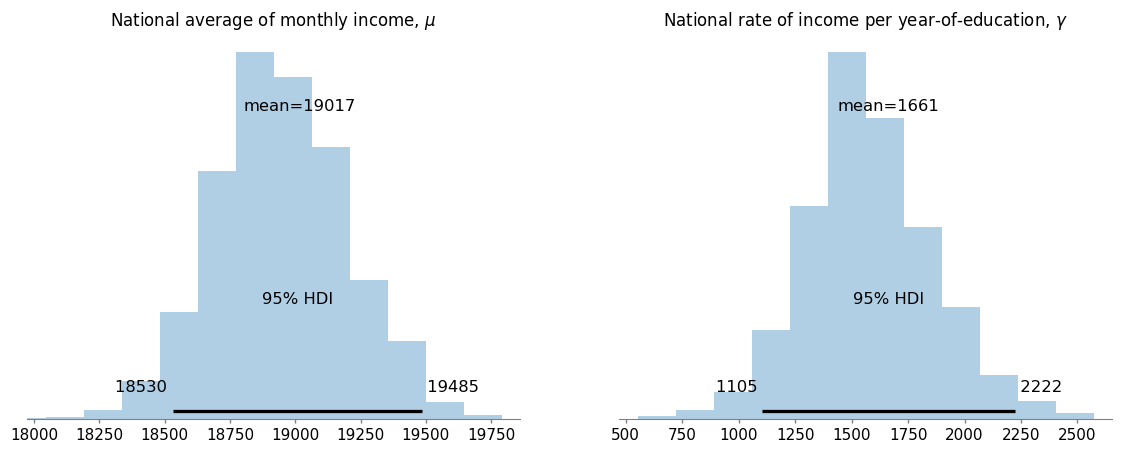

In [26]:
fig, axes = plt.subplots(1,2, figsize=(14,5))

az.plot_posterior(
    TraceVaryingAlphaVaryingBeta
    , var_names = ['Mu', 'Gamma']
    , hdi_prob = 1-ALPHA_LEVEL
    , kind = 'hist'
    , textsize=11
    , ax = axes
)

axes[0].set_title(r"National average of monthly income, $\mu$")
axes[1].set_title(r"National rate of income per year-of-education, $\gamma$")

In [27]:
PosteriorAlpha.round()

,HatAlpha,sd,LowAlpha,UppAlpha
AlphaBeta[0],21696.0,966.0,20020.0,23813.0
AlphaBeta[1],21877.0,392.0,21062.0,22561.0
AlphaBeta[2],18273.0,368.0,17598.0,18990.0
AlphaBeta[3],17997.0,365.0,17278.0,18650.0
AlphaBeta[4],17867.0,400.0,17117.0,18771.0
AlphaBeta[5],17087.0,357.0,16299.0,17728.0


In [28]:
PosteriorBeta.round()

,HatBeta,sd,LowBeta,UppBeta
AlphaBeta[0],1096.0,942.0,-922.0,2812.0
AlphaBeta[1],1585.0,593.0,380.0,2723.0
AlphaBeta[2],1780.0,636.0,605.0,3152.0
AlphaBeta[3],2317.0,909.0,852.0,4225.0
AlphaBeta[4],1164.0,565.0,60.0,2245.0
AlphaBeta[5],1367.0,534.0,210.0,2389.0


In [29]:
az.summary(
    TraceVaryingAlphaVaryingBeta
    , kind = 'stats'
    , hdi_prob = 1-ALPHA_LEVEL
    , var_names = 'Gamma'
).round()

,mean,sd,hdi_2.5%,hdi_97.5%
Gamma,1661.0,283.0,1105.0,2222.0


---

Creating a map of Thailand

In [30]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [31]:
ThailandMap = gpd.read_file("../../../Data/Enriched/ThailandMapProvinceIdRegion/ThailandMapProvinceIdRegion.shp")
ThailandMap = ThailandMap.rename(columns={'RegionInTh':'RegionInThai'})

ThailandMap = ThailandMap.drop(['NameInThai', 'Region', 'RegionInThai'], axis=1)

Add the province and region information

In [32]:
PosteriorAlpha['RegionNumber'] = range(J)
PosteriorAlpha['Region'] = PosteriorAlpha['RegionNumber'].replace(NumbersToRegions)

PosteriorBeta['RegionNumber'] = range(J)

In [33]:
Dat = pd.merge(Dat, PosteriorAlpha[['RegionNumber', 'Region', 'HatAlpha']])
Dat = pd.merge(Dat, PosteriorBeta[['RegionNumber', 'HatBeta']])

In [34]:
ThailandMap = pd.merge(
    ThailandMap
    , Dat[['ProvinceId', VARIABLE + 'Mean', 'Region', 'HatAlpha', 'HatBeta']].round()
    , how='left'
    , on='ProvinceId'
)

In [35]:
ThailandMap = ThailandMap.rename(columns={VARIABLE + 'Mean': VARIABLEPROVINCEMAP, 'HatAlpha': VARIABLEREGIONMAP, 'HatBeta': 'IncomeYearOfEducation'})

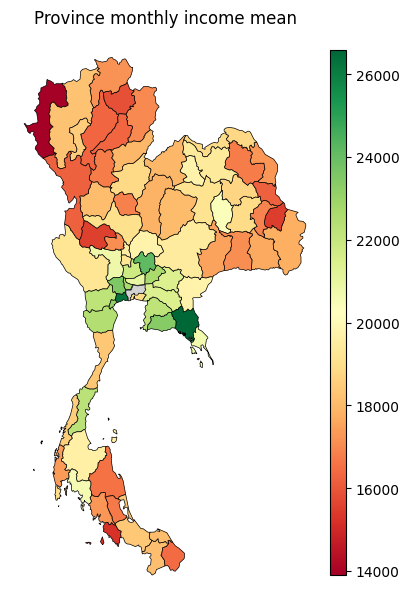

In [36]:
fig, ax = plt.subplots(figsize=(4,7.5))

ThailandMap.plot(
    VARIABLEPROVINCEMAP
    , ax = ax
    , cmap = 'RdYlGn'
    , edgecolor = 'k'
    , missing_kwds = {'color':'lightgrey', 'label':'No data'}
    , linewidth=0.5
).set_axis_off()

ax.set_title(VARIABLEPROVINCEMAP)

cbar = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=ThailandMap[VARIABLEPROVINCEMAP].min(), vmax=ThailandMap[VARIABLEPROVINCEMAP].max()))
cb_ax = fig.add_axes([0.925,0.15,0.04,0.7])
fig.colorbar(cbar, cax=cb_ax, orientation="vertical")

In [37]:
labels = ThailandMap[['Region', VARIABLEREGIONMAP]].drop_duplicates()
labels = labels[~labels[VARIABLEREGIONMAP].isnull()]

labels['Region'] = labels['Region'].replace(
    {
        'Northern Thailand': 'N'
        , 'Southern Thailand': 'S'
        , 'Northeastern Thailand': 'NE'
        , 'Northcentral Thailand': 'NC'
        , 'Central Thailand': 'C'
        , 'Bangkok - Pattaya': 'BP'
    }
)

labels = labels.sort_values(VARIABLEREGIONMAP)

labels_map = [labels['Region'][ind] + ': ' + str(int(labels[VARIABLEREGIONMAP][ind])) for ind in labels.index]
labels_map.append('BKK: No data')

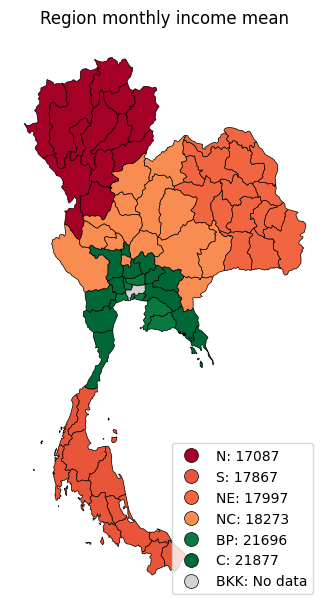

In [38]:
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

vmin = ThailandMap[VARIABLEREGIONMAP].min()
vmax = ThailandMap[VARIABLEREGIONMAP].max()

fig, ax = plt.subplots(figsize=(4,7.5))

vals = (ThailandMap[VARIABLEREGIONMAP]).unique()
vals = vals[~np.isnan(vals)]
vals.sort()

ThailandMap.plot(
    VARIABLEREGIONMAP
    , categorical = True
    , ax = ax
    , legend = True
    , cmap = LinearSegmentedColormap.from_list('my_cmap', colors = mpl.colormaps['RdYlGn']((vals - vmin) / (vmax - vmin)))
    , edgecolor = 'k'
    , missing_kwds = {'color':'lightgrey', 'label':'BKK'}
    , legend_kwds = {'loc':'lower right', 'labels':labels_map}
    , linewidth=0.5,  # Borderline width
).set_axis_off()

for legend_handle in ax.get_legend().legendHandles:
        legend_handle.set_markeredgewidth(0.5)
        legend_handle.set_markeredgecolor('k')

ax.set_title(VARIABLEREGIONMAP)

In [39]:
labels = ThailandMap[['Region', 'IncomeYearOfEducation']].drop_duplicates()
labels = labels[~labels['IncomeYearOfEducation'].isnull()]

labels['Region'] = labels['Region'].replace(
    {
        'Northern Thailand': 'N'
        , 'Southern Thailand': 'S'
        , 'Northeastern Thailand': 'NE'
        , 'Northcentral Thailand': 'NC'
        , 'Central Thailand': 'C'
        , 'Bangkok - Pattaya': 'BP'
    }
)

labels = labels.sort_values('IncomeYearOfEducation')

labels_map = [labels['Region'][ind] + ': ' + str(int(labels['IncomeYearOfEducation'][ind])) for ind in labels.index]
labels_map.append('BKK: No data')

Text(0.5, 1.0, 'Rate income per year-of-education')

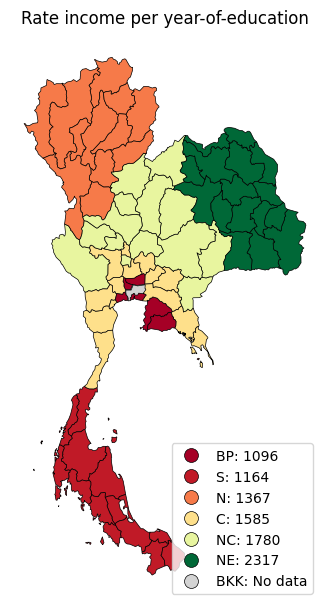

In [40]:
vmin = ThailandMap['IncomeYearOfEducation'].min()
vmax = ThailandMap['IncomeYearOfEducation'].max()

fig, ax = plt.subplots(figsize=(4,7.5))

vals = (ThailandMap['IncomeYearOfEducation']).unique()
vals = vals[~np.isnan(vals)]
vals.sort()

ThailandMap.plot(
    'IncomeYearOfEducation'
    , categorical = True
    , ax = ax
    , legend = True
    , cmap = LinearSegmentedColormap.from_list('my_cmap', colors = mpl.colormaps['RdYlGn']((vals - vmin) / (vmax - vmin)))
    , edgecolor = 'k'
    , missing_kwds = {'color':'lightgrey', 'label':'BKK'}
    , legend_kwds = {'loc':'lower right', 'labels':labels_map}
    , linewidth=0.5,  # Borderline width
).set_axis_off()

for legend_handle in ax.get_legend().legendHandles:
        legend_handle.set_markeredgewidth(0.5)
        legend_handle.set_markeredgecolor('k')

ax.set_title('Rate income per year-of-education')

---

We obtain the average distribution for $\alpha, \beta$

In [41]:
MeanMuGamma = np.array(
    [float(TraceVaryingAlphaVaryingBeta.posterior.Mu.mean()), float(TraceVaryingAlphaVaryingBeta.posterior.Gamma.mean())]
)

CholModel = pm.expand_packed_triangular(
    2, TraceVaryingAlphaVaryingBeta.posterior.chol_cov.mean(dim=("chain", "draw")).values, lower=True
).eval()

SigmaAlphaBeta = np.dot(CholModel, CholModel.T)

We see how changes from separate models and complete pooling to the partial pooled model

In [42]:
AlphaCommon = TraceCommonAlphaCommonBeta.posterior.Alpha.mean(('chain', 'draw'))
BetaCommon = TraceCommonAlphaCommonBeta.posterior.Beta.mean(('chain', 'draw'))

AlphaSeparate = TraceSeparateAlphaSeparateBeta.posterior.Alpha.mean(('chain', 'draw'))
BetaSeparate = TraceSeparateAlphaSeparateBeta.posterior.Beta.mean(('chain', 'draw'))

AlphaBetaPartialPooled = TraceVaryingAlphaVaryingBeta.posterior.AlphaBeta.mean(('chain', 'draw')).T
AlphaPartialPooled = AlphaBetaPartialPooled[0]
BetaPartialPooled = AlphaBetaPartialPooled[1]

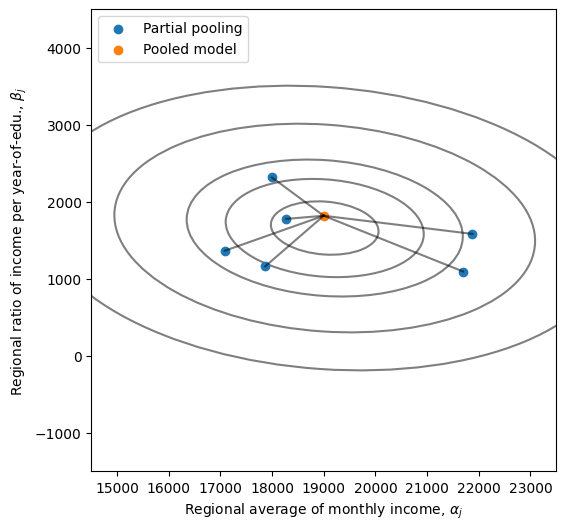

In [43]:
_, ax = plt.subplots(1, 1, figsize=(6, 6))
_ = Gauss2d(mu=MeanMuGamma, cov=np.asarray(SigmaAlphaBeta), ci=[0.1, 0.3, 0.5, 0.8, 0.95], ax=ax)

ax.scatter(AlphaPartialPooled, BetaPartialPooled, label="Partial pooling")
ax.scatter(AlphaCommon, BetaCommon, label="Pooled model")

ax.plot([[AlphaCommon]*J, AlphaPartialPooled], [[BetaCommon]*J, BetaPartialPooled], "k-", alpha=0.5)

ax.set_xlabel(r"Regional average of monthly income, $\alpha_j$")
ax.set_ylabel(r"Regional ratio of income per year-of-edu., $\beta_j$")
ax.set_xlim(14500, 23500)
ax.set_ylim(-1500, 4500)
plt.legend(loc='upper left', fontsize=10)

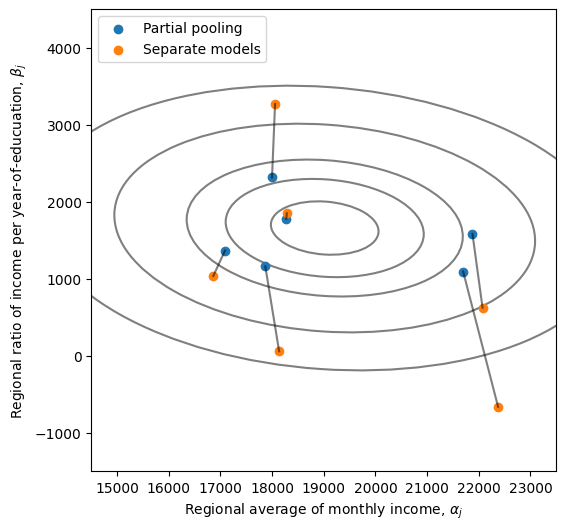

In [44]:
_, ax = plt.subplots(1, 1, figsize=(6, 6))
_ = Gauss2d(mu=MeanMuGamma, cov=np.asarray(SigmaAlphaBeta), ci=[0.1, 0.3, 0.5, 0.8, 0.95], ax=ax)

ax.scatter(AlphaPartialPooled, BetaPartialPooled, label="Partial pooling")
ax.scatter(AlphaSeparate, BetaSeparate, label="Separate models")

ax.plot([AlphaSeparate, AlphaPartialPooled], [BetaSeparate, BetaPartialPooled], "k-", alpha=0.5)

ax.set_xlabel(r"Regional average of monthly income, $\alpha_j$")
ax.set_ylabel(r"Regional ratio of income per year-of-educuation, $\beta_j$")
ax.set_xlim(14500, 23500)
ax.set_ylim(-1500, 4500)
plt.legend(loc='upper left', fontsize=10)

---

Posterior predictive

In [45]:
if False:
    _, axes = plt.subplots(1,1)
    az.plot_ppc(TraceVaryingAlphaVaryingBeta, ax=axes)
    axes.set_xlabel(VARIABLE2)

Scatterplot

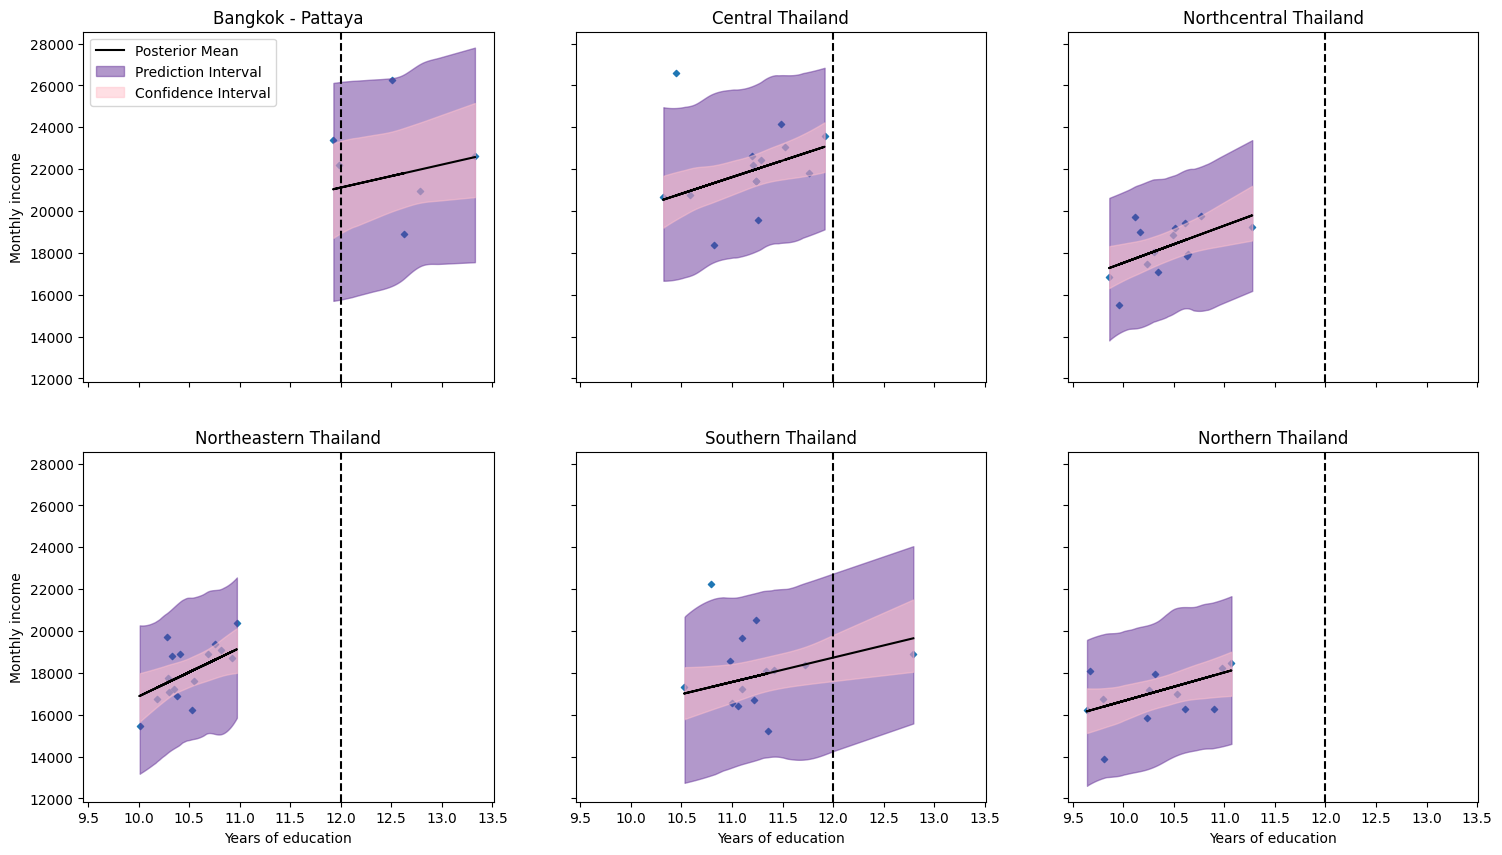

In [46]:
fig, axs = plt.subplots(2, 3, sharey=True, sharex=True, figsize=(18,10))

for k, ax in enumerate(axs.reshape(-1)):
    Aux = Dat[Dat['RegionNumber']==k]

    ax.scatter(
        Aux[PREDICTOR]
        , Aux[VARIABLE + 'Mean']
        , marker = 'D'
        , s = 10
    )

    ax.plot(
        Aux[PREDICTOR]
        , TraceVaryingAlphaVaryingBeta.posterior.MeanIncome[:,:,Aux.index].mean(('chain', 'draw'))
        , label="Posterior Mean"
        , color='k'
    )

    ax.axvline(12, linestyle='--', color='k')

    az.plot_hdi(
        Aux[PREDICTOR]
        , TraceVaryingAlphaVaryingBeta.posterior_predictive.Income[:,:,Aux.index]
        , hdi_prob=1-ALPHA_LEVEL
        , color='rebeccapurple'
        , fill_kwargs={'alpha': 0.5, 'label':"Prediction Interval"}
        , ax = ax
    )

    az.plot_hdi(
        Aux[PREDICTOR]
        , TraceVaryingAlphaVaryingBeta.posterior.MeanIncome[:,:,Aux.index]
        , hdi_prob=1-ALPHA_LEVEL
        , color='pink'
        , fill_kwargs={'alpha': 0.5, 'label':"Confidence Interval"}
        , ax = ax
    )

    ax.set_title(NumbersToRegions[k])

    if k in [0,3]:
        ax.set_ylabel(VARIABLE2)
        
        if k == 0:
            ax.legend()

    if k in [3,4,5]:
        ax.set_xlabel(PREDICTOR2)

---

Comparing the models

In [47]:
with pm.Model() as ModelVaryingAlphaCommonBeta:

    Tau   = pm.Exponential('Tau', lam=1/HatMeanTau)
    Mu    = pm.Normal('Mu', mu=HatMeanMu, sigma=HatStdMu) # National average income
    Alpha = pm.Normal('Alpha', mu=Mu, sigma=Tau, shape=J) # Regional average income

    Beta = pm.Normal('Beta', mu=HatMeanGamma, sigma=HatStdGamma)

    Rho = pm.HalfFlat('Rho')
    pm.Potential('p(Rho)', -pm.math.log(Rho))

    Nu = pm.Exponential('Nu', lam=1/HatNu)

    Sigma2 = pm.InverseGamma('Sigma2', alpha=Nu/2, beta=Nu/2 * Rho**2, shape=J)
    Sigma  = pm.Deterministic('Sigma', pm.math.sqrt(Sigma2))

    MeanIncome = pm.Deterministic(
        'MeanIncome'
        , Alpha[Dat['RegionNumber']] + Beta * (Dat[PREDICTOR] - Dat[PREDICTOR + 'Region']))

    Income = pm.Normal(
        'Income'
        , mu = MeanIncome
        , sigma = Sigma[Dat['RegionNumber']]
        , observed = Dat[VARIABLE + 'Mean']
    )

Get a sample from the posterior and the posterior predictive

In [48]:
with ModelVaryingAlphaCommonBeta:
    TraceVaryingAlphaCommonBeta = pm.sample()
    TraceVaryingAlphaCommonBeta.extend(pm.sample_posterior_predictive(TraceVaryingAlphaCommonBeta))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Tau, Mu, Alpha, Beta, Rho, Nu, Sigma2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [Income]


In [49]:
TraceVaryingAlphaCommonBeta

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [50]:
az.summary(
    TraceVaryingAlphaCommonBeta
    , kind = 'stats'
    , hdi_prob = 1-ALPHA_LEVEL
    , var_names = ['Alpha', 'Mu', 'Beta']
).round()

,mean,sd,hdi_2.5%,hdi_97.5%
Alpha[0],21753.0,978.0,19866.0,23684.0
Alpha[1],21830.0,546.0,20800.0,22945.0
Alpha[2],18311.0,355.0,17624.0,19010.0
Alpha[3],18078.0,339.0,17416.0,18732.0
Alpha[4],18197.0,497.0,17213.0,19149.0
Alpha[5],16946.0,419.0,16172.0,17831.0
Mu,19012.0,235.0,18557.0,19473.0
Beta,1547.0,273.0,1024.0,2078.0


Calculate the WAIC of the models

In [51]:
pm.compute_log_likelihood(TraceCommonAlphaCommonBeta, model = ModelCommonAlphaCommonBeta)
pm.compute_log_likelihood(TraceSeparateAlphaSeparateBeta, model = ModelSeparateAlphaSeparateBeta)
pm.compute_log_likelihood(TraceVaryingAlphaCommonBeta, model = ModelVaryingAlphaCommonBeta)
pm.compute_log_likelihood(TraceVaryingAlphaVaryingBeta, model = ModelVaryingAlphaVaryingBeta)

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [52]:
CompareTable = az.compare(
    {
        "National Model": TraceCommonAlphaCommonBeta
        , "Separate Model": TraceSeparateAlphaSeparateBeta
        , "Varying Intercept, Same Slope": TraceVaryingAlphaCommonBeta
        , "Varying Intercept, Varying Slope": TraceVaryingAlphaVaryingBeta
    }
    , ic = COMPARE_METRIC
    , scale = 'deviance'
)

In [53]:
CompareTable.round(2)

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
"Varying Intercept, Varying Slope",0,1347.14,13.74,0.00,0.51,16.01,0.00,True,deviance
"Varying Intercept, Same Slope",1,1348.54,11.42,1.40,0.42,17.76,5.80,True,deviance
Separate Model,2,1355.05,15.57,7.91,0.05,14.60,6.90,True,deviance
National Model,3,1387.06,4.04,39.92,0.02,18.20,14.17,True,deviance


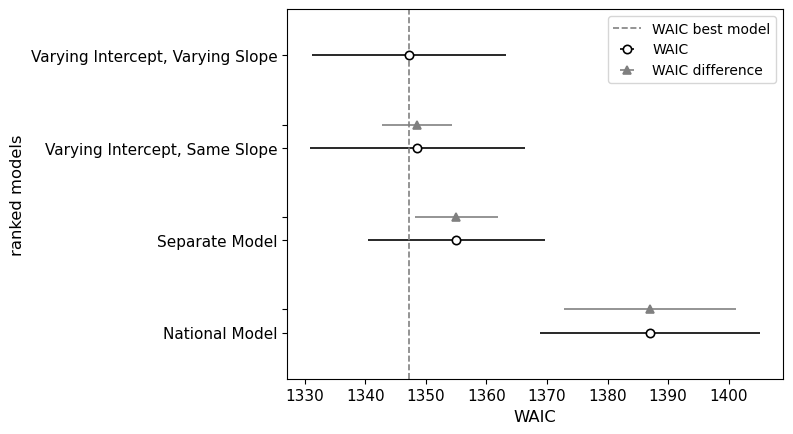

In [54]:
fig, axes = plt.subplots(1,1)

az.plot_compare(
    CompareTable
    , textsize = 11
    , figsize = (10,5)
    , ax = axes
    , title =  False
    )

axes.set_xlabel(str.upper(COMPARE_METRIC))
axes.legend([str.upper(COMPARE_METRIC) + " best model", str.upper(COMPARE_METRIC), str.upper(COMPARE_METRIC) + ' difference'])